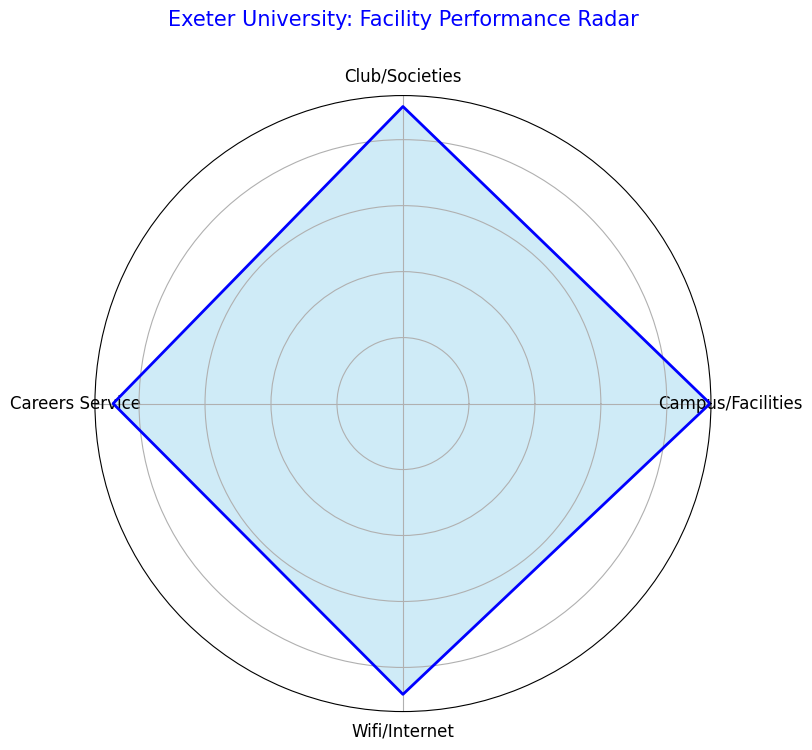

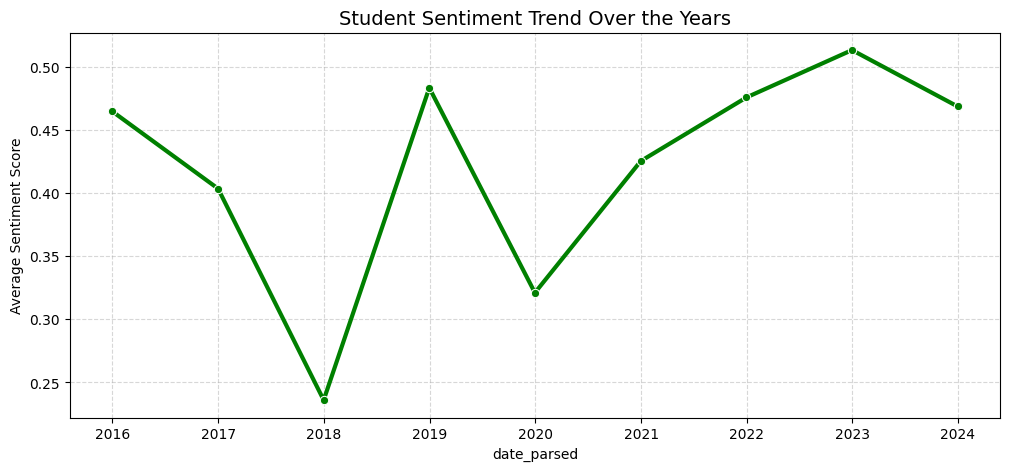

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import re

# 1. Load and Clean
df = pd.read_csv('ExeterReviews.csv')

# Clean dates (Handles 1st, 2nd, 3rd etc)
df['date_clean'] = df['Date'].apply(lambda x: re.sub(r'(\d+)(st|nd|rd|th)', r'\1', str(x)))
df['date_parsed'] = pd.to_datetime(df['date_clean'], format='%d %B %y', errors='coerce')

# 2. Innovative Feature: Sentiment vs. Subjectivity
# We check how opinionated (subjective) a student is versus how positive they are
df['sentiment'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# 3. INNOVATION: The University Radar Chart (Spider Plot)
# This shows the "Shape" of university performance across all categories
categories = ['Campus/Facilities', 'Club/Societies', 'Careers Service', 'Wifi/Internet']
values = df[categories].mean().tolist()
values += values[:1] # Repeat first value to close the circle

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1] # Repeat first angle to close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.4)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
plt.title('Exeter University: Facility Performance Radar', size=15, color='blue', y=1.1)
plt.show()

# 4. INNOVATION: Sentiment Trend Timeline
# Shows if the student experience is getting better or worse over time
df_trend = df.dropna(subset=['date_parsed']).set_index('date_parsed').resample('YE')['sentiment'].mean()
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_trend, marker='o', color='green', linewidth=3)
plt.title('Student Sentiment Trend Over the Years', fontsize=14)
plt.ylabel('Average Sentiment Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [2]:
# Identify "Disappointed" Students (High score but negative text)
# This helps find students who LIKE the uni but have one MAJOR complaint
disappointed = df[(df['Student Review'] >= 4) & (df['sentiment'] < 0)]

print("--- Top Hidden Issues (High Rated but Negative Comments) ---")
for i, row in disappointed[['Review', 'Wifi/Internet']].head(3).iterrows():
    print(f"Issue: {row['Review'][:150]}...")
    print(f"Wifi Score: {row['Wifi/Internet']}\n")

--- Top Hidden Issues (High Rated but Negative Comments) ---
Issue: Nothing can really complain except high tuition fees and less food choices, expensive meal deals too....
Wifi Score: 3

Issue: It can be a little tricky to get used to....
Wifi Score: 3

Issue: Very green university with lots of facilities....
Wifi Score: 5



/tmp/ipython-input-826189110.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranking['NSS'], y=ranking.index, palette="viridis")


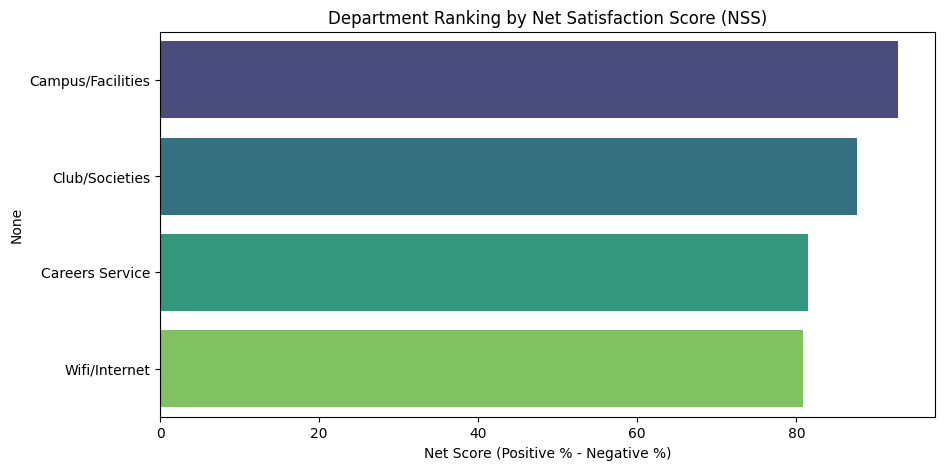

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'categories' are defined in a previous cell (e.g., Y6LJy3T2qR_D)
# categories = ['Campus/Facilities', 'Club/Societies', 'Careers Service', 'Wifi/Internet']

# Initialize an empty dictionary to store sentiment percentages for each category
sentiment_data = {}

# Ensure 'categories' is defined. If not, define it from the current context.
if 'categories' not in locals() and 'categories' not in globals():
    # Fallback definition if categories was not defined in the execution context
    # This should ideally come from a previous cell, but for robustness:
    categories = ['Campus/Facilities', 'Club/Societies', 'Careers Service', 'Wifi/Internet']

for category in categories:
    # Filter out NaN values for the current category
    category_ratings = df[category].dropna()

    # Define thresholds for positive and negative ratings (e.g., 4-5 is positive, 1-2 is negative)
    # Assuming ratings are on a 1-5 scale
    positive_ratings = category_ratings[category_ratings >= 4].count()
    negative_ratings = category_ratings[category_ratings <= 2].count()
    total_ratings = category_ratings.count()

    if total_ratings > 0:
        pct_positive = (positive_ratings / total_ratings) * 100
        pct_negative = (negative_ratings / total_ratings) * 100
    else:
        pct_positive = 0
        pct_negative = 0

    sentiment_data[category] = {1: pct_positive, -1: pct_negative}

# Create the sentiment_pct DataFrame
sentiment_pct = pd.DataFrame.from_dict(sentiment_data, orient='index')

# Calculate Net Satisfaction Score
sentiment_pct['NSS'] = sentiment_pct[1] - sentiment_pct[-1]

# Sort by best performing
ranking = sentiment_pct.sort_values('NSS', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=ranking['NSS'], y=ranking.index, palette="viridis")
plt.title('Department Ranking by Net Satisfaction Score (NSS)')
plt.xlabel('Net Score (Positive % - Negative %)')
plt.axvline(0, color='red', linestyle='--') # The danger line
plt.show()

/tmp/ipython-input-3810119165.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Student Review', y='sentiment_polarity', data=df, palette='viridis')


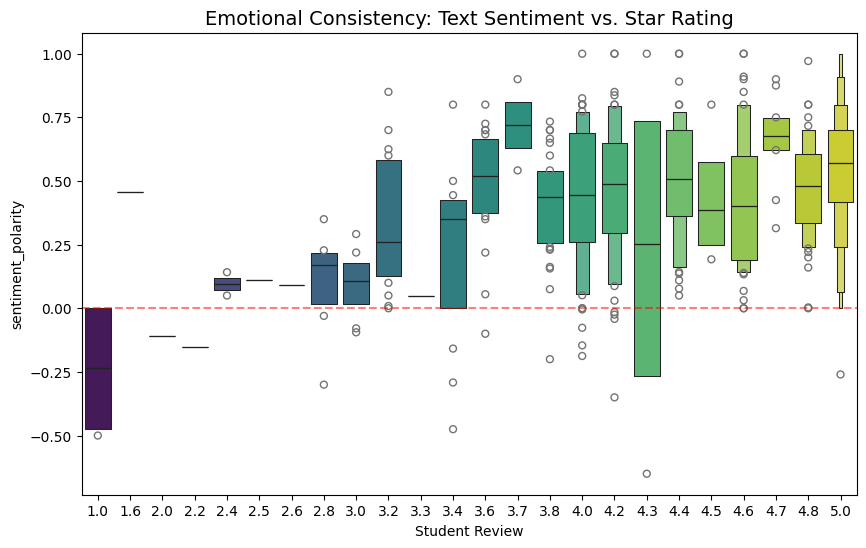

In [6]:
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

# Calculate sentiment
df['sentiment_polarity'] = df['Review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.boxenplot(x='Student Review', y='sentiment_polarity', data=df, palette='viridis')
plt.title('Emotional Consistency: Text Sentiment vs. Star Rating', fontsize=14)
plt.axhline(0, color='red', linestyle='--', alpha=0.5) # Neutral line
plt.show()

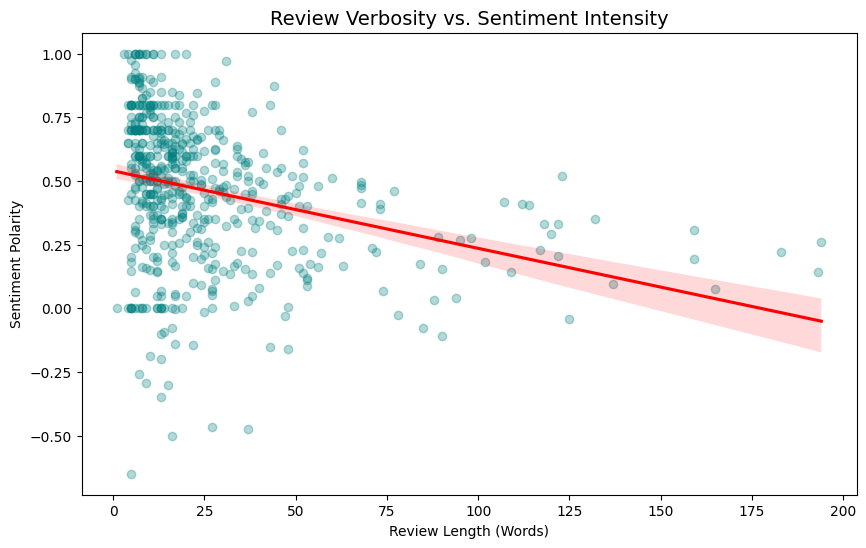

In [8]:
# Add word count column
df['word_count'] = df['Review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.regplot(x='word_count', y='sentiment_polarity', data=df,
            scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})
plt.title('Review Verbosity vs. Sentiment Intensity', fontsize=14)
plt.xlabel('Review Length (Words)')
plt.ylabel('Sentiment Polarity')
plt.show()

/tmp/ipython-input-1117624860.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Reds_r')


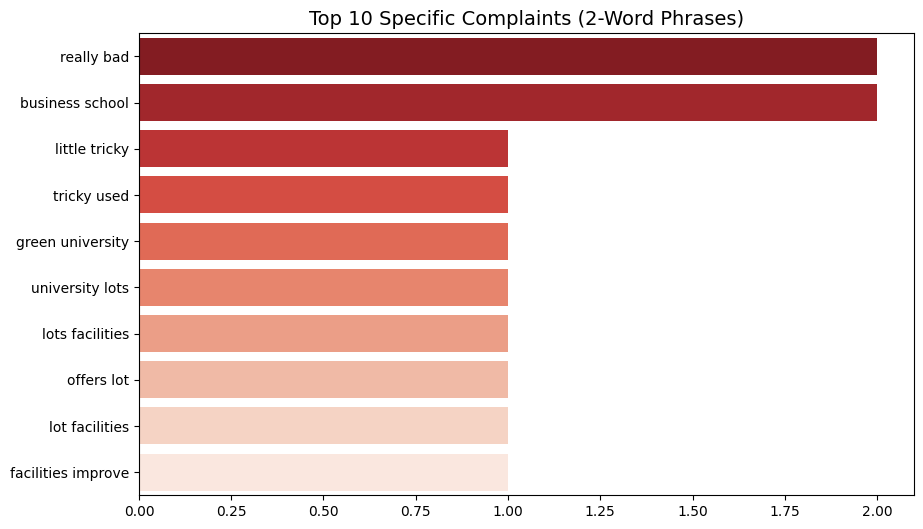

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Filter only negative reviews
negative_text = df[df['sentiment_polarity'] < -0.1]['Review']

# Get top 2-word phrases
cv = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(negative_text)
bag_of_words = cv.transform(negative_text)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

# Plot
words, counts = zip(*words_freq)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='Reds_r')
plt.title('Top 10 Specific Complaints (2-Word Phrases)', fontsize=14)
plt.show()

/tmp/ipython-input-1707532216.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (performance[i], impact[i]), xytext=(10, 10),
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


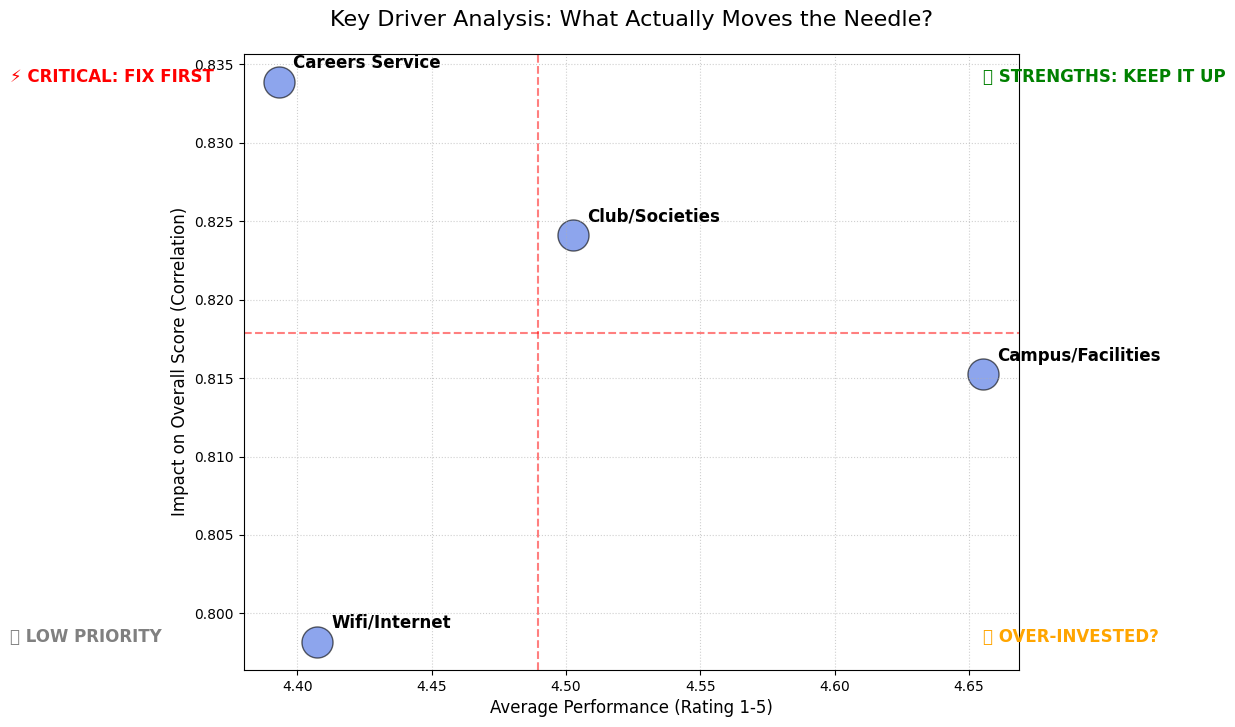

--- Strategic Priority List (High Impact / Low Performance) ---
Careers Service      0.189817
Club/Societies       0.183026
Wifi/Internet        0.181096
Campus/Facilities    0.175120
dtype: float64


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('ExeterReviews.csv')
facilities = ['Campus/Facilities', 'Club/Societies', 'Careers Service', 'Wifi/Internet']

# 2. Calculate Performance (Average Rating)
performance = df[facilities].mean()

# 3. Calculate Impact (Correlation with the Overall 'Student Review' score)
# This shows how much each facility actually "drives" the total score
impact = df[facilities].corrwith(df['Student Review'])

# 4. Create the Strategy Matrix
plt.figure(figsize=(10, 8))
plt.scatter(performance, impact, s=500, color='royalblue', alpha=0.6, edgecolors='black')

# Add labels to the dots
for i, txt in enumerate(facilities):
    plt.annotate(txt, (performance[i], impact[i]), xytext=(10, 10),
                 textcoords='offset points', fontsize=12, fontweight='bold')

# Create Quadrant Lines (Using means as the center point)
plt.axvline(performance.mean(), color='red', linestyle='--', alpha=0.5)
plt.axhline(impact.mean(), color='red', linestyle='--', alpha=0.5)

# Add Quadrant Labels
plt.text(performance.min()-0.1, impact.max(), "⚡ CRITICAL: FIX FIRST", color='red', fontsize=12, fontweight='bold')
plt.text(performance.max(), impact.max(), "🌟 STRENGTHS: KEEP IT UP", color='green', fontsize=12, fontweight='bold')
plt.text(performance.min()-0.1, impact.min(), "💤 LOW PRIORITY", color='grey', fontsize=12, fontweight='bold')
plt.text(performance.max(), impact.min(), "🔧 OVER-INVESTED?", color='orange', fontsize=12, fontweight='bold')

plt.title('Key Driver Analysis: What Actually Moves the Needle?', fontsize=16, pad=20)
plt.xlabel('Average Performance (Rating 1-5)', fontsize=12)
plt.ylabel('Impact on Overall Score (Correlation)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 5. Print the Strategic Recommendation
priority = (impact / performance).sort_values(ascending=False)
print("--- Strategic Priority List (High Impact / Low Performance) ---")
print(priority)